In [1]:
import torch
import torch.nn as nn
import numpy as np
import yaml
import os
import json
import io
from PIL import Image

from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import transforms

from pytorch_metric_learning import losses

from model import get_backbone, supConClas, clasifier
from loss import (
    plot_pca,
    calcualate_inner_outer_distances,
    contrastiveLoss,
    calculate_pca_analysis,
    plot_pca_2,
)
from utils import parse_training_conf

from data import clasDataset, get_transforms, weldingData
from torch.utils.data import DataLoader


/home/andrii/anaconda3/envs/venv_base/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/andrii/adient/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/andrii/adient/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/andrii/adient/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [62]:
dataset_config_path = '/home/andrii/adient/11multiclass/configs/dataset_config.yaml' 
training_config_path = '/home/andrii/adient/11multiclass/configs/training_conf.yaml'

training_config_file = open(training_config_path, 'r')
training_config_data = yaml.safe_load(training_config_file)

batch_size = training_config_data['batch_size']
device = torch.device(training_config_data['device'])
lr = training_config_data['lr']
num_epochs = training_config_data['num_epochs']
batch_size = training_config_data['batch_size']
threshold = training_config_data['threshold']

n_embeddings = training_config_data['n_embeddings']
pca_save_path = training_config_data['pca_save_path']
text_report_path = training_config_data['text_reports_folder_path']

log_dir_contrast = training_config_data['log_dir_contrast']  
log_dir_classifier = training_config_data['log_dir_classification']

contrast_save_path = training_config_data['conrast_weights_save_path']
clasifier_save_path = training_config_data['clasifier_head_save_path']

dataset_info_path = training_config_data['dataset_info_path']
save_distro_json_path = training_config_data['store_json_distro']
train_test_data = training_config_data['train_test_split_json']



contrast_writer = SummaryWriter(log_dir_contrast)
clasifier_writer = SummaryWriter(log_dir_classifier)

to_ten = transforms.ToTensor()

print(f'batch size: {batch_size}')
print(f'learning rate: {lr}')
print(f'num embeddings: {n_embeddings}')
print(f'contrast logs: {log_dir_contrast}')
print(f'clasisifer logs : {log_dir_classifier}')
print(f'contrsat weights: {contrast_save_path}')
print(f'clasifier weiights: {clasifier_save_path}')
print(f'json distro path : {save_distro_json_path}')
print(f'train test split json: {train_test_data}')
print(f'pca : {pca_save_path}')


torch.cuda.empty_cache()


batch size: 5
learning rate: 0.01
num embeddings: 128
contrast logs: /home/andrii/adient/11multiclass/contrast_logs
clasisifer logs : /home/andrii/adient/11multiclass/class_logs
contrsat weights: /home/andrii/adient/11multiclass/weights/projection_layer.pt
clasifier weiights: /home/andrii/adient/11multiclass/weights/clasifier_head.pt
json distro path : /home/andrii/adient/11multiclass/distro.json
train test split json: /home/andrii/adient/welding_data/train_test.json
pca : /home/andrii/adient/11multiclass/pca


In [63]:
wd = weldingData(dataset_config_path = dataset_config_path,
                   training_config_path = training_config_path)
wd.load(train_test_data)

train_trans, test_trans = get_transforms(training_config_path = training_config_path)
train_dataset = clasDataset(wd.train_dict, wd.idx2class, wd.class2idx, train_trans) 
test_dataset = clasDataset(wd.test_dict, wd.idx2class, wd.class2idx, test_trans)

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader  = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

In [64]:
t = wd.describe()
with open(dataset_info_path, 'w') as dataset_info:
    dataset_info.write(t)

Num images: 149 
Num train : 103 
Num test  : 46 
JSON path : /home/andrii/adient/welding_data/train_test.json 
 

VOCABULARY 
Healthy : 0 
Porosity : 1 
Oil : 2 
Skip : 3 
BurnThrough : 4 
BlowHole : 5 
Nothces : 6 
UnstableWeld : 7 
WireStick : 8 
Undercut : 9 
LackofFusion : 10 
Crater : 11 

 
CLASS DISTRIBUTION 
Healthy : 31 
Porosity : 19 
Oil : 9 
Skip : 10 
BurnThrough : 10 
BlowHole : 10 
Nothces : 10 
UnstableWeld : 10 
WireStick : 10 
Undercut : 10 
LackofFusion : 10 
Crater : 10 



In [65]:
wd.save(save_distro_json_path)

In [5]:
num_classes = len(wd.idx2class)

backbone = get_backbone(size = 'small')
criterion = losses.ArcFaceLoss(num_classes = num_classes, embedding_size = n_embeddings)
model = supConClas(backbone, n_embeddings)
optimizer2 = torch.optim.Adam(list(model.parameters()) + list(criterion.parameters()), lr = lr)

In [6]:
model.train()
model.to(device)
criterion = criterion.to(device)

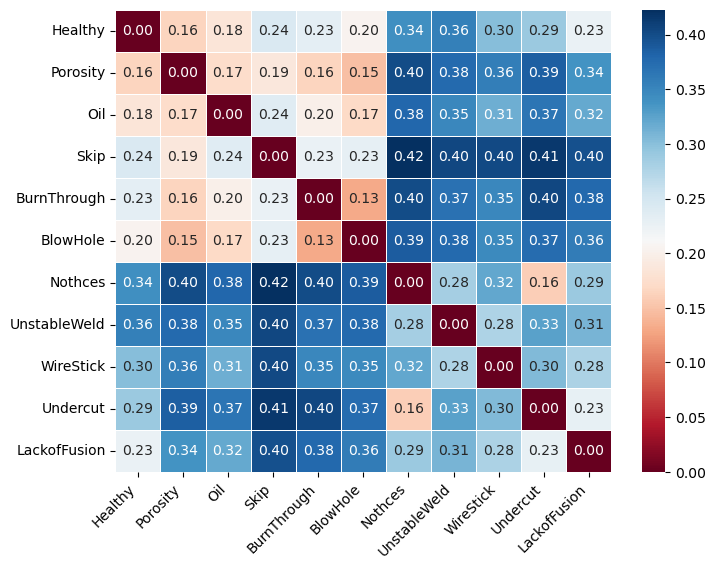

In [7]:
best_val_loss = torch.inf

for epoch in range(num_epochs):
    model.train()
    training_loss = 0
    for idx, (image, label) in enumerate(train_dataloader):
        optimizer2.zero_grad()
        images = image.to(device)
        label  = label.to(device)
        features = model(images)
        loss = criterion(features, label)
        loss.backward()
        training_loss += loss.item() 
        optimizer2.step()
        break
    training_loss/=(idx +1 )
    
    
    val_loss = 0
    model.eval()
    all_features = torch.zeros((1,model.n_embeddings))
    all_labels = torch.tensor([])
    
    for idx, (image, label) in enumerate(test_dataloader):
        images = image.to(device)
        label  = label.to(device)
        with torch.no_grad():
            features = model(images)
        features2 = features.cpu()
        all_features = torch.cat([all_features, features2], dim = 0)
        all_labels = torch.cat([all_labels, label.cpu()])
        loss = criterion(features, label)
        val_loss += loss.item()
    val_loss /= (idx +1 )
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), contrast_save_path)
        
    all_features = all_features[1:,:]   
    inner_d, outer_d = calcualate_inner_outer_distances(all_features.detach(), all_labels.detach())
    if epoch % 4 == 0:
        pca2 = calculate_pca_analysis(all_features.detach(), all_labels.detach())
        plot_pca_2( all_labels.detach(),pca2, test_dataloader.dataset.idx2class, pca_save_path, epoch)
        distance_matrix = np.zeros((num_classes, num_classes))
        outer_d2 = list(outer_d)
        for i in range(num_classes):
            for j in range(i + 1, num_classes):
                distance_matrix[i, j] = outer_d2.pop(0)
                distance_matrix[j, i] = distance_matrix[i, j]

        plt.figure(figsize=(8, 6))
        ax = plt.gca()
        a = sns.heatmap(distance_matrix, cmap='RdBu', annot=True, fmt=".2f", linewidths=.5, ax=ax)
        ax.set_xticklabels(wd.idx2class.values(), rotation=45, ha='right', fontsize=10)
        ax.set_yticklabels(wd.idx2class.values(), fontsize=10, rotation = 0)
        fig = a.get_figure()
        fig.savefig(f"{pca_save_path}/out_contrast.png") 

        image = Image.open(f"{pca_save_path}/out_contrast.png")
        image_tensor = to_ten(image)
        contrast_writer.add_image(f'Distance_Matrix_Heatmap_{epoch}', image_tensor)

    contrast_writer.add_scalar("Train Loss", training_loss, epoch)
    contrast_writer.add_scalar("Test Loss", val_loss, epoch)
    inner_distances = {f'InnerDistance_c{i}' : inner_d[i] for i in range(len(inner_d))}
    contrast_writer.add_scalars('InnerDistances', inner_distances, global_step=epoch)
    


    break
        
        

In [8]:
torch.cuda.empty_cache()

In [9]:

backbone = get_backbone(size = 'small')
supConModel = supConClas(backbone, n_embeddings)
supConModel.load_state_dict(torch.load(contrast_save_path))

<All keys matched successfully>

In [10]:
res_model = clasifier(backbone = supConModel, num_classes = num_classes, threshold = threshold)

optimizer = torch.optim.Adam(res_model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [11]:
res_model = res_model.to(device)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [03:39<00:00, 24.44s/it]


 model saved: /home/andrii/adient/10multiclass/weights/clasifier_head.pt


/home/andrii/anaconda3/envs/venv_base/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrii/anaconda3/envs/venv_base/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andrii/anaconda3/envs/venv_base/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

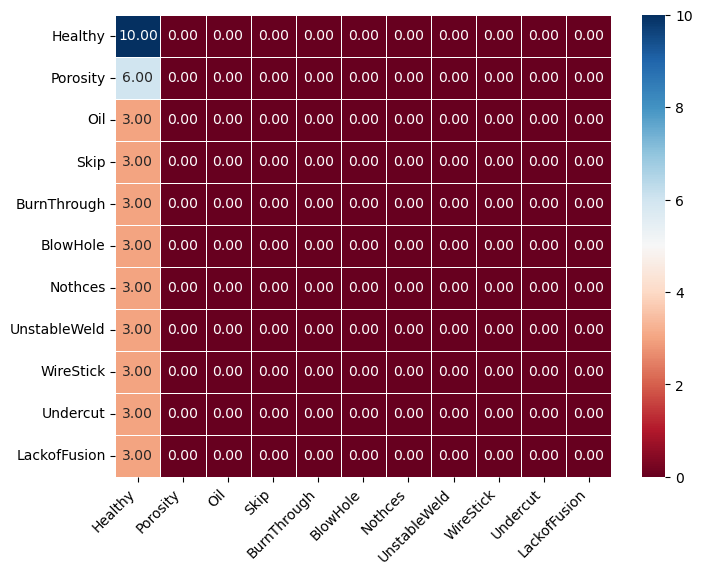

In [14]:
best_val_loss = torch.inf
for epoch in range(num_epochs):
    train_loss = 0
    res_model.train()


    for idx, (image, label) in enumerate(train_dataloader):
        optimizer.zero_grad()
        image = image.to(device)
        label = label.to(device)
        probs = res_model(image)
        loss = criterion(probs, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        break
    train_loss/= (idx + 1)
    
    test_loss = 0
    res_model.eval()
    all_predictions = []
    all_labels = []
    for idx, (image, label) in enumerate(tqdm(test_dataloader)):
        image = image.to(device)
        label = label.to(device)
        
        with torch.no_grad():
            probs, preds = res_model(image, return_predictions = True)
        
        loss = criterion(probs, label)
        test_loss += loss.item()
        batch_labels = label.cpu().numpy()
        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels)
    test_loss/= (idx + 1)
    
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        torch.save(res_model.state_dict(), clasifier_save_path)
        print(f' model saved: {clasifier_save_path}')
    
    
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')



    class_names = test_dataloader.dataset.idx2class.values()
    report = classification_report(all_labels, all_predictions, target_names=class_names)


    confusion = confusion_matrix(all_labels, all_predictions)
    report = classification_report(all_labels, all_predictions, target_names=class_names)
    with open(f'{text_report_path}/report_{epoch}.txt', 'w') as report_file:
        report_file.write(report)

    clasifier_writer.add_text(f"Classification Report_{epoch}", report, global_step=epoch)
    clasifier_writer.add_scalar("Train Loss", train_loss, epoch)
    clasifier_writer.add_scalar("Test Loss", test_loss, epoch)
    clasifier_writer.add_scalar("Accuracy", accuracy, epoch)
    clasifier_writer.add_scalar("Precision", precision, epoch)
    clasifier_writer.add_scalar("Recall", recall, epoch)
    clasifier_writer.add_scalar("F1", f1, epoch)
    if epoch % 4 == 0 or epoch == num_epochs - 1:
        plt.figure(figsize=(8, 6))
        ax = plt.gca()
        a = sns.heatmap(confusion, cmap='RdBu', annot=True, fmt=".2f", linewidths=.5, ax=ax)
        ax.set_xticklabels(wd.idx2class.values(), rotation=45, ha='right', fontsize=10)
        ax.set_yticklabels(wd.idx2class.values(), fontsize=10, rotation = 0)
        fig = a.get_figure()
        fig.savefig(f"{pca_save_path}/out_class.png") 

        image = Image.open(f"{pca_save_path}/out_class.png")
        image_tensor = to_ten(image)
        clasifier_writer.add_image(f'Distance_Matrix_Heatmap_{epoch}', image_tensor)

    break
    